<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/tutorials/W2D4_GenerativeModels/W2D4_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D4_GenerativeModels/W2D4_Tutorial3.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 3: Conditional GANs and Implications of GAN Technology

**Week 2, Day 4: Generative Models**

**By Neuromatch Academy**

__Content creators:__ Seungwook Han, Kai Xu, Akash Srivastava

__Content reviewers:__ Polina Turishcheva, Melvin Selim Atay, Hadi Vafaei, Deepak Raya, Kelson Shilling-Scrivo

__Content editors:__ Spiros Chavlis

__Production editors:__ Arush Tagade, Gagana B, Spiros Chavlis

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---

## Tutorial Objectives

The goal of this tutorial is to understand conditional GANs. Then you will have the opportunity to experience first-hand how effective GANs are at modeling the data distribution and to question what the consequences of this technology may be.

By the end of this tutorial you will be able to:
- Understand the differences in conditional GANs.
- Generate high-dimensional natural images from a BigGAN.
- Understand the efficacy of GANs in modeling the data distribution (e.g., faces).
- Understand the energy inefficiency / environmental impact of training these large generative models.
- Understand the implications of this technology (ethics, environment, *etc*.).


In [1]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/ps28k/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for the videos in this tutorial. If you want to locally download the slides, click [here](https://osf.io/ps28k/download).

---
# Setup

In [2]:
# @title Install dependencies
# @markdown Install *Huggingface BigGAN* library
!pip install pytorch-pretrained-biggan --quiet
!pip install Pillow libsixel-python --quiet
!pip install nltk --quiet

!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet

from evaltools.airtable import AirtableForm
atform = AirtableForm('appn7VdPRseSoMXEG', 'W2D4_T3','https://portal.neuromatchacademy.org/api/redirect/to/ddf809a2-5590-4d71-a764-1572e85dce27')

In [3]:
# Imports
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

from pytorch_pretrained_biggan import BigGAN
from pytorch_pretrained_biggan import one_hot_from_names
from pytorch_pretrained_biggan import truncated_noise_sample

In [4]:
# @title Figure settings
import ipywidgets as widgets       # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [5]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [6]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [7]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


In [8]:
# @title Download `wordnet` dataset

# import nltk
# nltk.download('wordnet')

import os, requests, zipfile

os.environ['NLTK_DATA'] = '/home/media/data1/DataAnalysis/data_ML/nltk_data/'


if not os.path.exists('/home/media/data1/DataAnalysis/data_ML/nltk_data/corpora'):
  fnames = ['wordnet.zip', 'omw-1.4.zip']
  urls = ['https://osf.io/ekjxy/download', 'https://osf.io/kuwep/download']

  for fname, url in zip(fnames, urls):
    r = requests.get(url, allow_redirects=True)

    with open(fname, 'wb') as fd:
      fd.write(r.content)

    with zipfile.ZipFile(fname, 'r') as zip_ref:
      zip_ref.extractall('nltk_data/corpora')
    os.remove(fname)
else:
  print('Wordnet is already downloaded')

Wordnet is already downloaded


---
# Section 1: Generating with a conditional GAN (BigGAN)

In [9]:
# @title Video 1: Conditional Generative Models
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1f54y1E79D", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"lV6zH2xDZck", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 1: Conditional Generative Models')

display(out)

In this section, we will load a pre-trained conditional GAN, BigGAN, which is the state-of-the-art model in conditional high-dimensional natural image generation, and generate samples from it. Since it is a class conditional model, we will be able to use the class label to generate images from the different classes of objects.

Read here for more details on BigGAN: [Brock et al., 2019](https://arxiv.org/abs/1809.11096).

In [10]:
def load_biggan(model_res):
  """
  Load respective BigGAN model for the specified resolution (biggan-deep-128, biggan-deep-256, biggan-deep-512)
  """
  return BigGAN.from_pretrained('biggan-deep-{}'.format(model_res))


def create_class_noise_vectors(class_str, trunc, num_samples):
  """
  Create class and noise vectors for sampling from BigGAN

  Args:
    class_str: string
      Class
    trunc: float
      Truncation factor
    num_samples: int
      Number of samples

  Returns:
    class_vector: np.ndarray
      Class vector sampled from BigGan
    noise_vector: np.ndarray
      Noise vector
  """
  class_vector = one_hot_from_names([class_str]*num_samples, batch_size=num_samples)
  noise_vector = truncated_noise_sample(truncation=trunc, batch_size=num_samples)

  return class_vector, noise_vector

def generate_biggan_samples(model, class_vector, noise_vector, device,
                            truncation=0.4):
  """
  Generate samples from BigGAN

  Args:
    model: nn.module
      Model
    device: string
      GPU if available. CPU otherwise.
    truncation: float
      Truncation factor
    class_vector: np.ndarray
      Class vector sampled from BigGan
    noise_vector: np.ndarray
      Noise vector

  Returns:
    output_grid: torch.tensor
      Make grid and display generated samples
  """
  # Convert to tensor
  noise_vector = torch.from_numpy(noise_vector)
  class_vector = torch.from_numpy(class_vector)

  # Move to GPU
  noise_vector = noise_vector.to(device)
  class_vector = class_vector.to(device)
  model.to(device)

  # Generate an image
  with torch.no_grad():
      output = model(noise_vector, class_vector, truncation)

  # Back to CPU
  output = output.to('cpu')

  # The output layer of BigGAN has a tanh layer, resulting the range of [-1, 1] for the output image
  # Therefore, we normalize the images properly to [0, 1] range.
  # Clipping is only in case of numerical instability problems

  output = torch.clip(((output.detach().clone() + 1) / 2.0), 0, 1)
  output = output

  # Make grid and show generated samples
  output_grid = torchvision.utils.make_grid(output,
                                            nrow=min(4, output.shape[0]),
                                            padding=5)
  plt.imshow(output_grid.permute(1, 2, 0))

  return output_grid


def generate(b):
  """
  Generation function

  Args:
    None

  Returns:
    Nothing
  """
  # Create BigGAN model
  model = load_biggan(MODEL_RESOLUTION)

  # Use specified parameters (resolution, class, number of samples, etc) to generate from BigGAN
  class_vector, noise_vector = create_class_noise_vectors(CLASS, TRUNCATION,
                                                          NUM_SAMPLES)
  samples_grid = generate_biggan_samples(model, class_vector, noise_vector,
                                         DEVICE, TRUNCATION)
  torchvision.utils.save_image(samples_grid, 'samples.png')
  ### If CUDA out of memory issue, lower NUM_SAMPLES (number of samples)

## Section 1.1:  Define configurations

We will now define the configurations (resolution of model, number of samples, class to sample from, truncation level) under which we will sample from BigGAN. 

***Question***: What is the truncation trick employed by BigGAN? How does sample variety and fidelity change by varying the truncation level? (Hint: play with the truncation slider and try sampling at different levels) 

In [11]:
# @title { run: "auto" }

### RUN THIS BLOCK EVERY TIME YOU CHANGE THE PARAMETERS FOR GENERATION

# Resolution at which to generate
MODEL_RESOLUTION = "128" # @param [128, 256, 512]

# Number of images to generate
NUM_SAMPLES = 4 # @param {type:"slider", min:4, max:12, step:4}

# Class of images to generate
CLASS = 'German shepherd'  # @param ['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee', 'acoustic guitar', 'coffee mug', 'minibus', 'monitor']

# Truncation level of the normal distribution we sample z from
TRUNCATION = 0.4  # @param {type:"slider", min:0.1, max:1, step:0.1}

Button(button_style='danger', description='GENERATE!', layout=Layout(height='80px', width='30%'), style=Button…

Output()

100%|██████████| 630/630 [00:00<00:00, 291142.74B/s]


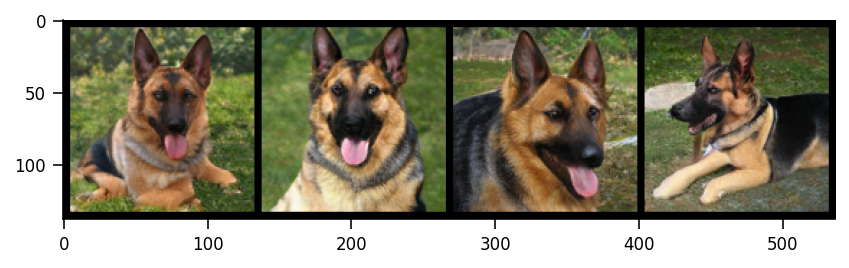

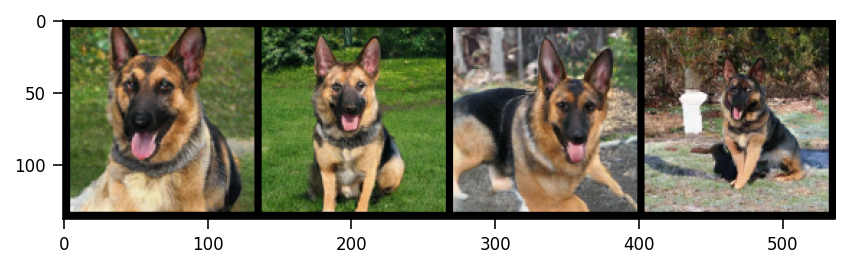

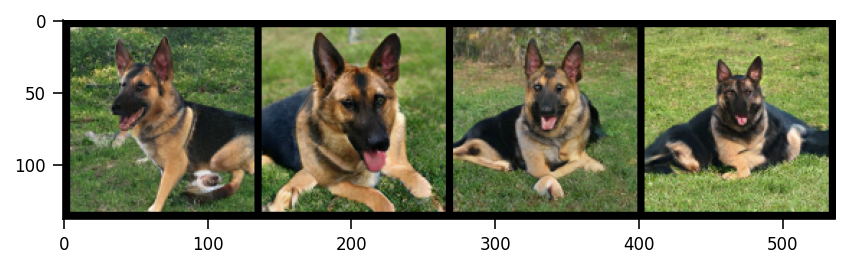

In [12]:
# @title Generate
# Create generate button, given parameters specified above
button = widgets.Button(description="GENERATE!",
                        layout=widgets.Layout(width='30%', height='80px'),
                        button_style='danger')
output = widgets.Output()
display(button, output)
button.on_click(generate)

## Think! 1: BigGANs

1. How does BigGAN differ from previous state-of-the-art generative models for high-dimensional natural images? In other words, how does BigGAN solve high-dimensional image generation? (Hint: look into model architecture and training configurations) (BigGAN paper: [Brock et al., 2018](https://arxiv.org/abs/1809.11096))
2. Continuing from Question 1, what are the drawbacks of introducing such techniques into training large models for high-dimensional, diverse datasets?
3. Play with other pre-trained generative models like StyleGAN here -- where code for sampling and interpolation in the latent space is available [here](https://github.com/NVlabs/stylegan)

In [ ]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type answer here and Push submit',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q1' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

In [ ]:
# to_remove explanation

"""
1
  - Very large mini-batch sizes (>= 2048) -- along with synchronous batch
    normalization across all GPUs / mini-batches to address the high diversity
    of the ImageNet dataset
  - Increased number of parameters (at least double of previous state-of-the-art
    models like SAGAN) (from increased widths of the layers)
  - Spectral normalization, orthogonal regularization penalty, and dropouts
    in final layer of D to stabilize the highly unstable training of BigGAN.
    Even with these stabilization techniques, BigGAN still suffers from chronic
    instability (as described in the paper) and requires multiple restarts.
    The model almost always collapses at some point in the training, but the key
     is to stop the training before it does.

2. Huge compute requirement to allow for large mini-batch sizes and therefore
   high energy consumption

""";

---
# Section 2: Ethical issues

In [13]:
# @title Video 2: Ethical Issues
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV11L411H7pr", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"ZtWFeUZgfVk", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 2: Ethical Issues')

display(out)

## Section 2.1: Faces Quiz 

Now is your turn to test your abilities on recognizing a real vs. a fake image!

In [14]:
# @markdown Real or Fake?
from IPython.display import IFrame
IFrame(src='https://docs.google.com/forms/d/e/1FAIpQLSeGjn2S2bn6Q1qWjVgDS5LG7G1GsQQh2Q0T9dEUO1z5_W0yYg/viewform?usp=sf_link', width=900, height=600)

## Section 2.2: Energy Efficiency Quiz 

In [15]:
# @markdown Make a guess
IFrame(src='https://docs.google.com/forms/d/e/1FAIpQLSe8suNt4ZmadSr_6IWq6s_nUYxC1VCpjR2cBBmQ7cR_5znCZw/viewform?usp=sf_link', width=900, height=600)

---
# Summary

Hooray! You have finished the second week of NMA-DL!!!

In the first section of this tutorial, we have learned: 
- How conditional GANs differ from unconditional models
- How to use a pre-trained BigGAN model to generate high-dimensional photo-realistic images and its tricks to modulate diversity and image fidelity

In the second section, we learned about the broader ethical implications of GAN technology on society through deepfakes and their tremendous energy inefficiency.

On the brighter side, as we learned throughout the week, GANs are very effective in modeling the data distribution and have many practical applications.

For example, as personalized healthcare and applications of AI in healthcare rise, the need to remove any Personally Identifiable Information (PII) becomes more important. As shown in [Piacentino and Angulo, 2020](https://doi.org/10.1007/978-3-030-45385-5_36), GANs can be leveraged to anonymize healthcare data.

As a food for thought, what are some other practical applications of GANs that you can think of? Discuss with your pod your ideas.

In [16]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/SurveyButton.png?raw=1"
 alt="button link end of day Survey" style="width:410px"></a>
   </div>""" )

In [17]:
# @title (Bonus) Video 3: Recap and advanced topics
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Uo4y1D7Nj", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"7nUjFG3N04I", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 3: Recap and advanced topics')

display(out)